# **Task 4 - Loan Approval Prediction**
- To predict loan application approvals based on applicant information.
- To handle missing values and encode categorical variables properly.
- To address imbalanced data using SMOTE and evaluate with precision, recall, and F1-score.

In [18]:
%matplotlib inline
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import warnings; warnings.filterwarnings("ignore")

#### **===== Load Data =====**

In [19]:
df = pd.read_csv("loan_approval_dataset.csv")
print("✅ Loaded:", df.shape)
print(df.head(3))

✅ Loaded: (5000, 14)
   Applicant_ID  Age  Income  Credit_Score  Loan_Amount  Loan_Term  \
0             1   56   21920           639       452748         72   
1             2   69  126121           655       257134         60   
2             3   46   96872           467       226437         72   

   Interest_Rate Employment_Status  Debt_to_Income_Ratio Marital_Status  \
0           4.53        Unemployed                 43.35        Married   
1           5.38        Unemployed                 10.42       Divorced   
2           3.46     Self-Employed                 45.39       Divorced   

   Number_of_Dependents Property_Ownership Loan_Purpose  Previous_Defaults  
0                     2           Mortgage     Business                  0  
1                     0           Mortgage    Education                  0  
2                     4           Mortgage          Car                  0  


#### **===== Data Cleaning =====**

In [20]:
df = df.drop_duplicates()

##### 1. Features & Target

In [21]:
X = df.drop(columns=["Previous_Defaults"])   # treat Previous_Defaults as target
y = df["Previous_Defaults"]

##### 2. Identify numeric & categorical columns

In [22]:
num_cols = X.select_dtypes(include=["int64","float64"]).columns.tolist()
cat_cols = X.select_dtypes(exclude=["int64","float64"]).columns.tolist()

#### **===== Train/Test Split =====**

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

#### **===== Preprocessing =====**

In [24]:


numeric_tf = Pipeline([("scaler", StandardScaler())])
categorical_tf = Pipeline([("ohe", OneHotEncoder(handle_unknown="ignore"))])

pre = ColumnTransformer(
    transformers=[
        ("num", numeric_tf, num_cols),
        ("cat", categorical_tf, cat_cols)
    ]
)

#### **===== Helper for model evaluation =====**

In [25]:
def fit_eval(model, name):
    pipe = Pipeline([("pre", pre), ("clf", model)])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    print(f"\n===== {name} =====")
    print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted"); plt.ylabel("Actual")
    plt.show()
    return pipe

#### **===== Models =====**


===== Logistic Regression =====
Accuracy: 0.901
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       901
           1       0.00      0.00      0.00        99

    accuracy                           0.90      1000
   macro avg       0.45      0.50      0.47      1000
weighted avg       0.81      0.90      0.85      1000



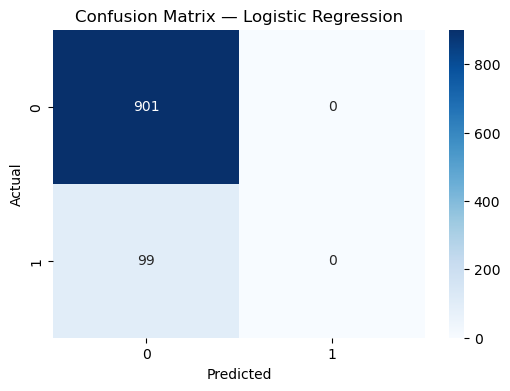


===== Decision Tree =====
Accuracy: 0.814
              precision    recall  f1-score   support

           0       0.90      0.89      0.90       901
           1       0.11      0.12      0.11        99

    accuracy                           0.81      1000
   macro avg       0.51      0.51      0.51      1000
weighted avg       0.82      0.81      0.82      1000



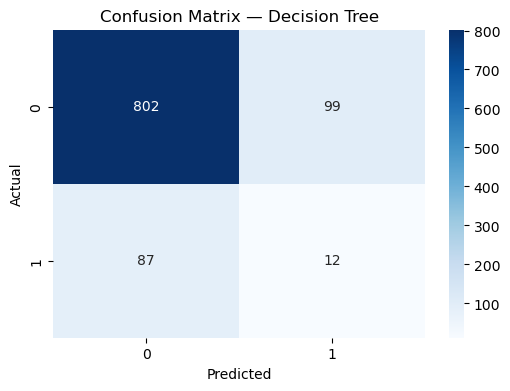


===== Random Forest =====
Accuracy: 0.901
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       901
           1       0.00      0.00      0.00        99

    accuracy                           0.90      1000
   macro avg       0.45      0.50      0.47      1000
weighted avg       0.81      0.90      0.85      1000



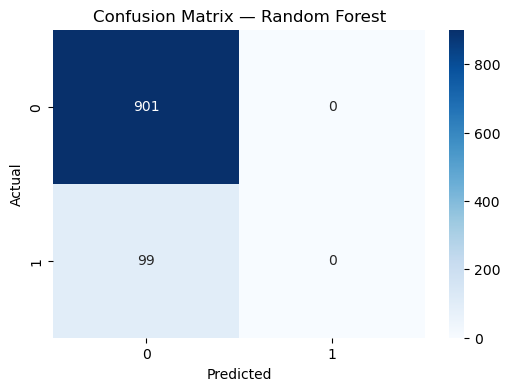

In [26]:
pipe_lr = fit_eval(LogisticRegression(max_iter=2000, n_jobs=-1), "Logistic Regression")
pipe_dt = fit_eval(DecisionTreeClassifier(random_state=42), "Decision Tree")
pipe_rf = fit_eval(RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1), "Random Forest")

#### **===== Feature Importance (for trees) =====**

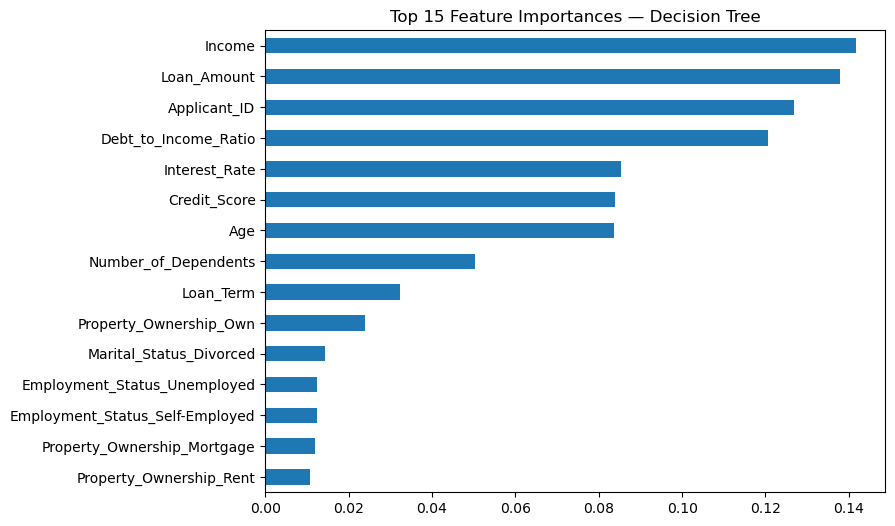

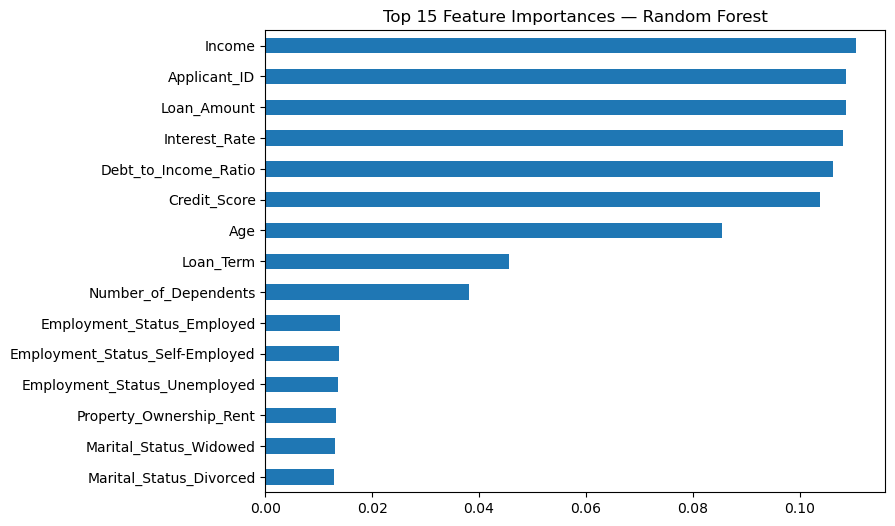

In [27]:
def plot_importance(pipe, name):
    ohe = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["ohe"] if len(cat_cols) else None
    cat_features = ohe.get_feature_names_out(cat_cols).tolist() if ohe is not None else []
    all_features = num_cols + cat_features
    clf = pipe.named_steps["clf"]
    if hasattr(clf, "feature_importances_"):
        importances = pd.Series(clf.feature_importances_, index=all_features).sort_values(ascending=False)[:15]
        plt.figure(figsize=(8,6))
        importances.iloc[::-1].plot(kind="barh")
        plt.title(f"Top 15 Feature Importances — {name}")
        plt.show()

plot_importance(pipe_dt, "Decision Tree")
plot_importance(pipe_rf, "Random Forest")

#### **===== Bonus: Hyperparameter Tuning (RF) =====**

In [28]:

param_grid = {
    "clf__n_estimators": [100, 200],
    "clf__max_depth": [5, 10, None],
    "clf__min_samples_split": [2, 5]
}
rf_grid = Pipeline([("pre", pre), ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))])
grid = GridSearchCV(rf_grid, param_grid, cv=3, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)
print("\nBest RF Params:", grid.best_params_)
print("Best RF CV Accuracy:", round(grid.best_score_, 4))


Best RF Params: {'clf__max_depth': 5, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
Best RF CV Accuracy: 0.9005
